In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import time
import os
import pandas as pd
from sklearn.metrics import auc



In [8]:

!apt-get install unrar -y > /dev/null
!pip install rarfile --quiet


import os
import requests
import rarfile
import shutil

MODEL_URL = "https://www.dropbox.com/scl/fi/71drtjqgzlkx13iw7t4xd/autoencoder.h5?rlkey=204kqn6r57hf6lrjyp4pximao&st=u2msov9u&dl=1"
RAR_URL = "https://www.dropbox.com/scl/fi/pvpndpwtyvxolsnu55zpj/test.rar?rlkey=98iyw8f39yfl925dwdxl48x5j&dl=1"



MODEL_PATH = "autoencoder.h5"
RAR_PATH = "test.rar"


target_test_image = "crack_segmentation/test/img"
target_test_gt = "crack_segmentation/test/ann"


def download_file(url, filename):
    print(f"Downloading from {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    print(f"Saved to {filename}")

# === Download model and dataset ===
download_file(MODEL_URL, MODEL_PATH)
download_file(RAR_URL, RAR_PATH)




Saved to autoencoder.h5
Saved to test.rar


In [9]:

print("Extracting .rar archive...")
with rarfile.RarFile(RAR_PATH) as rf:
    rf.extractall("crack_segmentation/")
print("Extraction complete.")


if os.path.exists(target_test_image) and os.path.exists(target_test_gt):
    print(" Test image and annotation directories are ready!")
else:
    print(" Extraction failed or paths are incorrect.")

Extracting .rar archive...
Extraction complete.
 Test image and annotation directories are ready!


In [10]:

def evaluate_segmentation(y_true, y_pred, alpha=None, threshold=0.5):
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)
    y_true_bin = (y_true >= threshold).astype(np.uint8)
    sum_gt=np.sum(y_true_bin == 1)
    #print("sum gt",sum_gt)
    if(sum_gt>200):

        tp = np.sum((y_true_bin == 1) & (y_pred_bin == 1))/sum_gt
    else:
        tp=np.sum(y_pred_bin == 0)/40000.

    sum_gt_ng=np.sum(y_true_bin == 0)
    if(sum_gt>200):
        fp = np.sum((y_true_bin == 0) & (y_pred_bin == 1))/sum_gt_ng
    else:
        fp=np.sum(y_pred_bin == 1)/40000.

    fn=0.
    if(sum_gt>200):
        fn = (np.sum((y_true_bin == 1) & (y_pred_bin == 0)))/sum_gt


    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    f1_score  = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0.0
    iou       = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0.0
    dice      = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0.0

    return {
        'alpha': alpha,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'IoU': iou,
        'Dice': dice
    }

In [11]:
def load_images_from_directory(directory_path, sort=True):

    image_list = []

    # Sort filenames to preserve order
    filenames = sorted(os.listdir(directory_path)) if sort else os.listdir(directory_path, sort=True)

    for filename in filenames:
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            file_path = os.path.join(directory_path, filename)
            img = cv2.imread(file_path)
            if img is not None:
                if img.shape[-1] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (200, 200))
                image_list.append(img)

    return np.array(image_list)


In [12]:

target_test_image="crack_segmentation/test/img"
target_test_gt="crack_segmentation/test/ann"



images_test= load_images_from_directory(target_test_image,True)
images_test=images_test[:,:,:,0]/255.
y_test=load_images_from_directory(target_test_gt,True)
y_test=y_test[:,:,:,0]/1.
y_test =np.where(np.logical_or.reduce((  y_test == 1,y_test == 3,y_test == 5, y_test == 6)), 1.0, 0.0)


In [13]:
#load the model
autoencoder=tf.keras.models.load_model('autoencoder.h5')
autoencoder.summary()




Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 1,369,857 (5.23 MB)

 Trainable params: 1,367,681 (5.22 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [14]:
alpha = 0.7  # Just to save with a flag alpha
Thresh=0.02  # You can try other threshold
option_data=0 # choose option: if you want to compute metrics on images with defaults choose 1 ......
Type_data=["all","Only_default","Only_intact"]

results = []


In [15]:

# Inference and evaluation loop
for idx in range(len(images_test)):
    x_input = np.expand_dims(images_test[idx], axis=0)  # shape: (1, 200, 200, 1)
    y_true = y_test[idx]  # shape: (200, 200)


    output = autoencoder.predict(x_input, verbose=0)
    y_pred = output[0, :, :, 0]


    if y_pred.max() > 1:
        y_pred = y_pred / 255.0


    metrics = evaluate_segmentation(y_true, y_pred, alpha=alpha, threshold=Thresh)
    metrics['Image'] = f'test_image_{idx}.png'
    if option_data==0:
        results.append(metrics)
    elif option_data==1:
        if np.sum(y_true == 1)<200:
            results.append(metrics)
    else:
        if np.sum(y_true == 1)>200:
            results.append(metrics)


# Convert to DataFrame
df_results = pd.DataFrame(results)

# Print results
print(df_results.head())
mean_metrics = df_results.drop(columns=['Image']).mean()

print("Average Metrics:")
print(mean_metrics)


   alpha        TP        FP        FN  Precision    Recall  F1-Score  \
0    0.7  0.928475  0.071525  0.000000   0.928475  1.000000  0.962911   
1    0.7  0.979708  0.065260  0.020292   0.937548  0.979708  0.958165   
2    0.7  0.956700  0.043300  0.000000   0.956700  1.000000  0.977871   
3    0.7  0.949750  0.050250  0.000000   0.949750  1.000000  0.974227   
4    0.7  0.782516  0.039083  0.217484   0.952430  0.782516  0.859153   

        IoU      Dice             Image  
0  0.928475  0.962911  test_image_0.png  
1  0.919689  0.958165  test_image_1.png  
2  0.956700  0.977871  test_image_2.png  
3  0.949750  0.974227  test_image_3.png  
4  0.753083  0.859153  test_image_4.png  
Average Metrics:
alpha        0.700000
TP           0.944101
FP           0.056016
FN           0.025142
Precision    0.944384
Recall       0.974858
F1-Score     0.958494
IoU          0.922213
Dice         0.958494
dtype: float64


In [16]:

num=91 # Choose any number < 206
y_def=y_test[num]
image_cell=images_test[num]

predicted_output = autoencoder.predict(np.expand_dims(image_cell, axis=0))[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


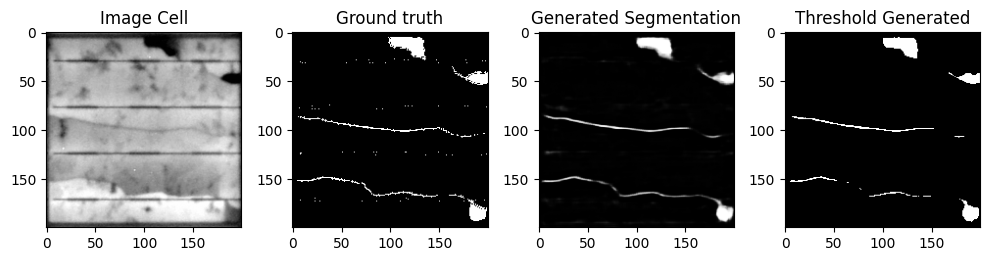

In [17]:


predicted_output_normalized = (predicted_output - np.min(predicted_output)) / (np.max(predicted_output) - np.min(predicted_output))
y_pred_binary = np.where(predicted_output_normalized >= 0.5, 1, 0)
fig, axs = plt.subplots(1, 4, figsize=(10, 5))


image_normalized = (image_cell - np.min(image_cell)) / (np.max(image_cell) - np.min(image_cell))
axs[0].imshow(image_normalized, cmap='gray')
axs[0].set_title('Image Cell')

axs[2].imshow(predicted_output_normalized, cmap='gray')
axs[2].set_title('Generated Segmentation')

axs[1].imshow(y_def, cmap='gray')
axs[1].set_title('Ground truth')

axs[3].imshow(y_pred_binary, cmap='gray')
axs[3].set_title('Threshold Generated')


plt.tight_layout()
#plt.savefig(r'C:\Users\elbahri\Documents\solar_pannel\result_pv_cell\output_all_' + str(num) + '.png', dpi=300, bbox_inches='tight')
# Show the combined plot
plt.show()